# RoboReviews Project
#### The new product review aggregator

## Phase 1: Setting up the environment

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import re
from transformers import RobertaTokenizer
from transformers import pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.utils import resample
from sklearn.model_selection import KFold
import numpy as np
import os
os.environ["WANDB_MODE"] = "disabled"



2024-10-17 09:41:26.760555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 09:41:26.760637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 09:41:26.761655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 09:41:26.767841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 09:41:27.664670: W tensorflow/compiler/tf2

#### Loading the Dataset and Explore

In [2]:
# Load the dataset
file_path = '/notebooks/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'  # Replace with the correct file path
df = pd.read_csv(file_path)

# Select the specified columns
columns_to_keep = ['name', 'brand', 'primaryCategories', 'reviews.text', 'reviews.rating']
df_selected = df[columns_to_keep]

# Show the first few rows to verify
df_selected.head()


,name,brand,primaryCategories,reviews.text,reviews.rating
0,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,I order 3 of them and one of the item is bad q...,3
1,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,Bulk is always the less expensive way to go fo...,4
2,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,Well they are not Duracell but for the price i...,5
3,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,Seem to work as well as name brand batteries a...,5
4,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,These batteries are very long lasting the pric...,5


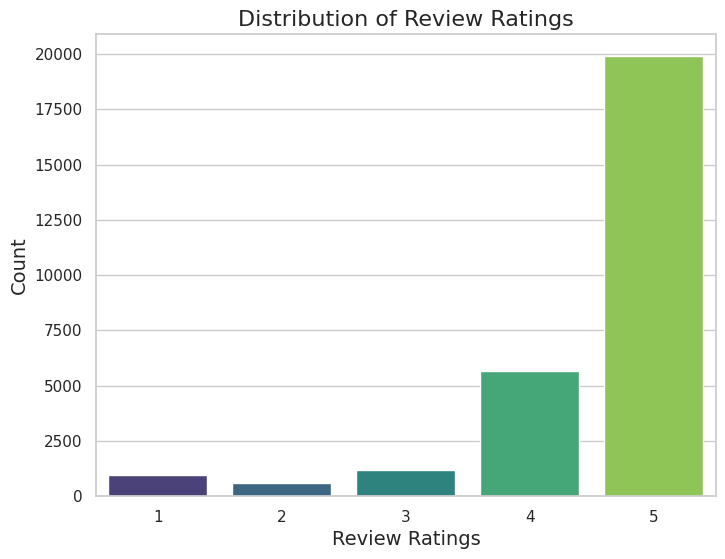

In [3]:
#Plotting to visualize data balances


# Set plot size and style
plt.figure(figsize=(8,6))
sns.set(style="whitegrid")

# Plot the distribution of ratings
sns.countplot(x='reviews.rating', data=df_selected, palette='viridis')

# Set title and labels
plt.title('Distribution of Review Ratings', fontsize=16)
plt.xlabel('Review Ratings', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show plot
plt.show()


Balance the data

In [4]:

positive_reviews = df_selected[df_selected['reviews.rating'] >= 4]
neutral_reviews = df_selected[df_selected['reviews.rating'] == 3]
negative_reviews = df_selected[df_selected['reviews.rating'] <= 2]

max_class_size = max(len(positive_reviews), len(neutral_reviews), len(negative_reviews))
positive_upsampled = resample(positive_reviews, replace=True, n_samples=max_class_size, random_state=42)
neutral_upsampled = resample(neutral_reviews, replace=True, n_samples=max_class_size, random_state=42)
negative_upsampled = resample(negative_reviews, replace=True, n_samples=max_class_size, random_state=42)

df_balanced = pd.concat([positive_upsampled, neutral_upsampled, negative_upsampled]).sample(frac=1, random_state=42)

df_balanced['labels'] = df_balanced['reviews.rating'].map(lambda rating: 0 if rating <= 2 else (1 if rating == 3 else 2))

# Verify class balance
print(df_balanced['reviews.rating'].value_counts())


reviews.rating
2    29856
0    25545
1    21234
Name: count, dtype: int64


Split the data

In [6]:
from sklearn.model_selection import train_test_split

# Split the dataset before tokenization (TO AVOID DATA LEAKAGE)
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['reviews.text'], df_balanced['reviews.rating'], test_size=0.2, random_state=42
)


In [7]:
# Ensure that X_train and y_train are Pandas DataFrames or Series before the loop
print(type(X_train))
print(type(y_train))


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Tokenization

In [8]:
from transformers import DistilBertTokenizer

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize training and testing sets with padding and truncation
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding='max_length', max_length=512, return_tensors='pt')
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding='max_length', max_length=512, return_tensors='pt')



In [9]:
# Print the shapes to verify consistency
print(f"Train encodings shape: {train_encodings['input_ids'].shape}")
print(f"Test encodings shape: {test_encodings['input_ids'].shape}")

# Check attention mask shapes
print(f"Train attention mask shape: {train_encodings['attention_mask'].shape}")
print(f"Test attention mask shape: {test_encodings['attention_mask'].shape}")

Train encodings shape: torch.Size([61308, 512])
Test encodings shape: torch.Size([15327, 512])
Train attention mask shape: torch.Size([61308, 512])
Test attention mask shape: torch.Size([15327, 512])


Create the Datasets with matching lenghts:

In [10]:
from datasets import Dataset

# Create HuggingFace Datasets for training and test data
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'].tolist(),
    'attention_mask': train_encodings['attention_mask'].tolist(),
    'labels': y_train.tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'].tolist(),
    'attention_mask': test_encodings['attention_mask'].tolist(),
    'labels': y_test.tolist()
})


In [11]:
# Verify the shape of the dataset to ensure proper tokenization
print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")


Train dataset length: 61308
Test dataset length: 15327


Integrating LoRA for fine-tuning

In [12]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import Dataset
import torch

# Assuming you have already tokenized the data correctly as seen in the previous images
# Tokenization (already done by you)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


In [13]:
from peft import LoraConfig, TaskType, get_peft_model

# Define LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification task
    r=8,  # Low-rank adaptation dimension
    lora_alpha=32,  # LoRA scaling factor
    lora_dropout=0.1,  # Dropout in LoRA layers
    target_modules=["q_lin", "v_lin"]  # Target modules for LoRA in DistilBERT (MultiHeadAttention)
)

# Load pretrained model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', 
    num_labels=3  # Adjust based on your labels (e.g. positive, negative, neutral)
)

# Wrap the model with LoRA using PEFT
model = get_peft_model(model, lora_config)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Adjust based on your need
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
    no_cuda=False  # Assuming you have a GPU, if not set to True
)


In [15]:
# Create HuggingFace Datasets for training and testing data (already done by you)
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'].tolist(),
    'attention_mask': train_encodings['attention_mask'].tolist(),
    'labels': y_train.tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'].tolist(),
    'attention_mask': test_encodings['attention_mask'].tolist(),
    'labels': y_test.tolist()
})

# Define the Trainer instance
trainer = Trainer(
    model=model,  # PEFT-wrapped model
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Fine-tune the model with LoRA
trainer.train()

def plot_metrics(trainer):
    # Convert log history to a DataFrame for easier plotting
    log_history = pd.DataFrame(trainer.state.log_history)

    # Plot Training Loss
    plt.figure(figsize=(10, 6))
    plt.plot(log_history['step'], log_history['loss'], label="Training Loss", color='blue')
    plt.title("Training Loss Over Time")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # If there are evaluation logs, plot validation loss and other metrics
    if 'eval_loss' in log_history.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(log_history['step'], log_history['eval_loss'], label="Validation Loss", color='red')
        plt.title("Validation Loss Over Time")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    if 'eval_accuracy' in log_history.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(log_history['step'], log_history['eval_accuracy'], label="Validation Accuracy", color='green')
        plt.title("Validation Accuracy Over Time")
        plt.xlabel("Step")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()


Epoch,Training Loss,Validation Loss
1,0.753700,0.726355
2,0.767300,0.612977


KeyboardInterrupt: 

In [16]:
print(trainer.state.log_history)


[{'loss': 1.0943, 'learning_rate': 1.9989561586638833e-05, 'epoch': 0.0, 'step': 10}, {'loss': 1.0869, 'learning_rate': 1.9979123173277665e-05, 'epoch': 0.01, 'step': 20}, {'loss': 1.0817, 'learning_rate': 1.9968684759916493e-05, 'epoch': 0.01, 'step': 30}, {'loss': 1.0881, 'learning_rate': 1.9958246346555325e-05, 'epoch': 0.01, 'step': 40}, {'loss': 1.0951, 'learning_rate': 1.9947807933194157e-05, 'epoch': 0.01, 'step': 50}, {'loss': 1.0932, 'learning_rate': 1.9937369519832988e-05, 'epoch': 0.02, 'step': 60}, {'loss': 1.0715, 'learning_rate': 1.992693110647182e-05, 'epoch': 0.02, 'step': 70}, {'loss': 1.072, 'learning_rate': 1.9916492693110648e-05, 'epoch': 0.02, 'step': 80}, {'loss': 1.0869, 'learning_rate': 1.990605427974948e-05, 'epoch': 0.02, 'step': 90}, {'loss': 1.0868, 'learning_rate': 1.989561586638831e-05, 'epoch': 0.03, 'step': 100}, {'loss': 1.0792, 'learning_rate': 1.9885177453027143e-05, 'epoch': 0.03, 'step': 110}, {'loss': 1.073, 'learning_rate': 1.9874739039665975e-05,

In [22]:
print(X_train.shape)


(61308,)


## Running Cross Validation in our model

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import numpy as np

# Define the number of splits (K in K-fold)
k_folds = 2
kf = KFold(n_splits=k_folds)

# Create empty lists to store the metrics for each fold
fold_metrics = []

X_train = X_train.iloc[:100]  # Limit to first 100 rows
y_train = y_train.iloc[:100]


# Assuming X_train and y_train are your features and labels (from the previous snippets)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Split the training and validation sets
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]

    # Load the model and fine-tune it on the fold training data (using LoRA as standard)
    trainer.train()

    # Generate predictions for the validation set
    predictions = trainer.predict(X_fold_val)
    
    # Convert predictions to labels (assumed argmax over logits)
    preds = np.argmax(predictions.predictions, axis=-1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_fold_val, preds)
    precision = precision_score(y_fold_val, preds, average='weighted')
    recall = recall_score(y_fold_val, preds, average='weighted')
    f1 = f1_score(y_fold_val, preds, average='weighted')
    
    # Store metrics for the current fold
    fold_metrics.append({
        'fold': fold + 1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# Calculate average metrics across all folds
avg_accuracy = np.mean([f['accuracy'] for f in fold_metrics])
avg_precision = np.mean([f['precision'] for f in fold_metrics])
avg_recall = np.mean([f['recall'] for f in fold_metrics])
avg_f1 = np.mean([f['f1'] for f in fold_metrics])

# Print out the results
print(f"Avg Accuracy: {avg_accuracy}")
print(f"Avg Precision: {avg_precision}")
print(f"Avg Recall: {avg_recall}")
print(f"Avg F1 Score: {avg_f1}")


Fold 1


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Saving the model under the name "fredsmeds_classifier"

In [ ]:
# Saving the model with a custom name
model.save_pretrained('./saved_model/fredsmeds_classifier')

# Saving the tokenizer with the same custom name
tokenizer.save_pretrained('./saved_model/fredsmeds_classifier')

# Optionally, save the training arguments if needed
training_args.save('./saved_model/fredsmeds_classifier/training_args.bin')


#--------------------------------------------TO LOAD THE MODEL LATER----------------------------------------------

#from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the saved model
#model = AutoModelForSequenceClassification.from_pretrained('./fredsmeds_classifier')

# Load the saved tokenizer
#tokenizer = AutoTokenizer.from_pretrained('./fredsmeds_classifier')
